In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLars
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
%matplotlib inline

In [2]:
# Query modeling_data2 table from PostgreSQL database

try:
    conn = psycopg2.connect(user="cohort17",
                            password="Cohort17Movies",
                            host="moviesdb.ce8d6g1pa5lm.us-east-1.rds.amazonaws.com",
                            port="5432",database="moviesdb")

    dbquery = "select * from modeling_data2"
    
    movies = pd.read_sql_query(dbquery, conn)

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    if(conn):
        conn.close()

In [57]:
# Create week_number feature from release date, create input and output datasets, and create train/test split

movies['releasedate']=pd.to_datetime(movies['releasedate'])
movies['release_year']=movies['releasedate'].dt.year
movies['release_week']=movies['releasedate'].dt.week

X = movies.drop(['primarytitle','releasedate','domesticgross'], axis=1)
#X = movies[['productionbudget','release_week','release_year']]
y = movies['domesticgross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [58]:
# Impute missing values in training and test datasets with median value from test dataset

median_imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=False, fill_value=None)
median_imputer.fit(X_train)
X_train = median_imputer.transform(X_train)
X_test = median_imputer.transform(X_test)

In [59]:
# Scale values of training and test datasets using min/max scaler fit on training dataset

scaler = MinMaxScaler(copy=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.5572372416104123

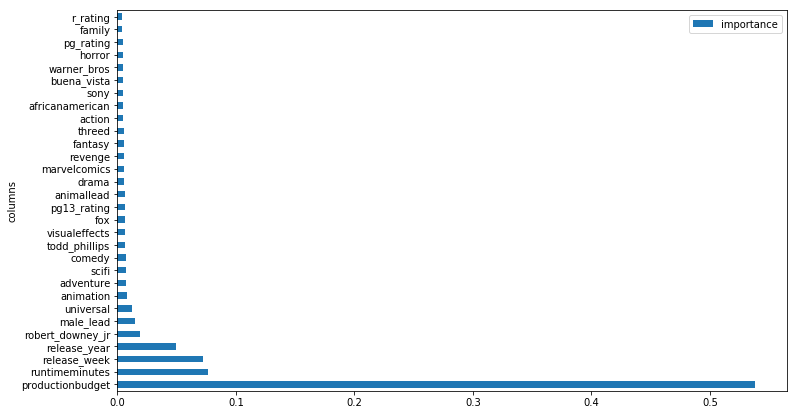

In [61]:
importance = pd.DataFrame({'columns':X.columns,'importance': rf.feature_importances_})
importance.sort_values('importance',ascending=False,inplace=True)
importance[:30].plot('columns','importance','barh',figsize=(12,7))

In [ ]:
rf = RandomForestRegressor()
random_grid = {'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4, 8, 10, 20, 30],
               'min_samples_split': [2, 4, 8, 10, 20, 30],
               'n_estimators': [50, 100, 150, 200]}
#Random search of parameters, using 5 fold cross validation, 
#search across 200 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 150, 
                               cv = 5, 
                               verbose=2, 
                               random_state=0, 
                               n_jobs = -1)
#Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.score(X_test,y_test)

In [7]:
en = ElasticNetCV(max_iter=1000, cv=5, random_state=0, l1_ratio=[.1, .3, .5, .7, .9, .95, .99, 1])
en.fit(X_train, y_train)
en.score(X_test, y_test)

0.5400146148961058

In [8]:
lars = LassoLars(max_iter=1000)
lars.fit(X_train, y_train)
lars.score(X_test, y_test)

0.5453111789079803

In [ ]:
lars = LassoLars()
random_grid = {'alpha':[.1, .3, .5, .7, .9, .95, .99, 1],
              'max_iter':[1000]}
lars_random = RandomizedSearchCV(estimator = lars,
                                param_distributions = random_grid,
                                n_iter = 150,
                                cv = 5,
                                verbose = 2,
                                random_state = 0,
                                n_jobs = -1)
lars_random.fit(X_train, y_train)
lars_random.score(X_test, y_test)

In [62]:
gbm = GradientBoostingRegressor(random_state=0)
gbm.fit(X_train,y_train)
gbm.score(X_test,y_test)

0.5763158094907829

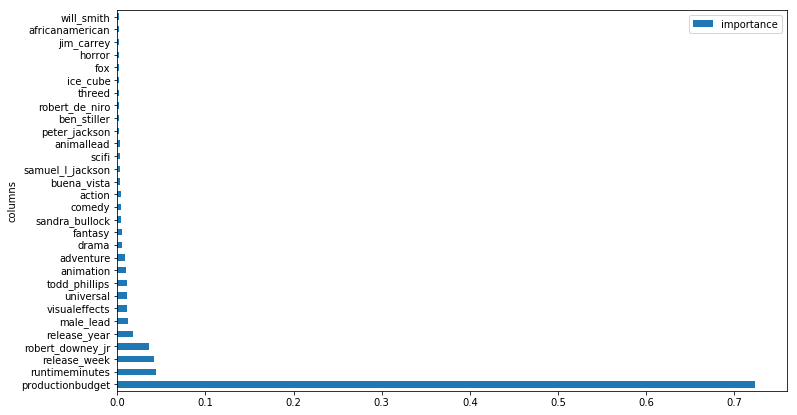

In [11]:
importance = pd.DataFrame({'columns':X.columns,'importance': gbm.feature_importances_})
importance.sort_values('importance',ascending=False,inplace=True)
importance[:30].plot('columns','importance','barh',figsize=(12,7))

In [ ]:
gbm = GradientBoostingRegressor()
random_grid = {'learning_rate': [.05, .1, .2, .3, .4, .5],
              'n_estimators': [50, 100, 200, 300, 400, 500],
              'subsample': [.3, .5, .7, .9, 1],
              'min_samples_split': [2, 4, 8, 10, 20],
              'min_samples_leaf': [1, 2, 4, 8, 10, 20],
              'max_depth': [3, 5, 7, 10],
              'max_features': ['auto','sqrt']}
gbm_random = RandomizedSearchCV(estimator = gbm,
                               param_distributions = random_grid,
                               n_iter = 500,
                               cv = 12,
                               verbose = 2,
                               random_state = 0,
                               n_jobs = -1)
gbm_random.fit(X_train, y_train)
gbm_random.score(X_test, y_test)

In [ ]:
gbm_random.best_estimator_

In [ ]:
#rf_random.best_estimator_